In [ ]:
#Imporing necessary librairies for the task
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
#Loading CIFAR10 and applying data transformation
#Transofming PIL images into PyTOrch images and normalizing the pixels values
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#Creating trainsets and testsets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:01<00:00, 100700311.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Define backbone
class NetWithPoolingAndDropout(nn.Module):
    def __init__(self):
        super(NetWithPoolingAndDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Define the model with the fully connected softmax output layer
class NetWithFullyConnectedOutput(nn.Module):
    def __init__(self):
        super(NetWithFullyConnectedOutput, self).__init__()
        self.backbone = NetWithPoolingAndDropout()
        self.fc_output = nn.Linear(10, 10)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc_output(x)
        return x

net_with_pooling_fc_output = NetWithFullyConnectedOutput()

In [ ]:
# Define the model with the max-pooling output layer
class NetWithPoolingOutput(nn.Module):
    def __init__(self):
        super(NetWithPoolingOutput, self).__init__()
        self.backbone = NetWithPoolingAndDropout()
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.fc_output = nn.Linear(16, 10)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pooling_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_output(x)
        return x


net_with_pooling_output = NetWithPoolingOutput()

In [ ]:
class NetWithPoolingAndDropout(nn.Module):
    def __init__(self):
        super(NetWithPoolingAndDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Fully connected softmax output model
class NetWithFullyConnectedOutput(nn.Module):
    def __init__(self):
        super(NetWithFullyConnectedOutput, self).__init__()
        self.backbone = NetWithPoolingAndDropout()
        self.fc_output = nn.Linear(10, 10)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc_output(x)
        return x

# Pooling-based output model
class NetWithPoolingOutput(nn.Module):
    def __init__(self):
        super(NetWithPoolingOutput, self).__init__()
        self.backbone = NetWithPoolingAndDropout()
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.backbone(x)
        #x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return x
net_with_pooling_fc_output = NetWithFullyConnectedOutput()
net_with_pooling_output = NetWithPoolingOutput()

# Training and comparing testing results

In [ ]:

# Training function
def train(net, optimizer, epochs=20):
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            #print (inputs)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}")
                running_loss = 0.0
        losses.append(running_loss / (i + 1))

    return losses

# Define optimizers and loss function
optimizer_fc_output = optim.SGD(net_with_pooling_fc_output.parameters(), lr=0.001, momentum=0.9)
optimizer_pooling_output = optim.SGD(net_with_pooling_output.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train models and collect losses
epochs = 1
#losses_fc_output = train(net_with_pooling_fc_output, optimizer_fc_output, epochs)
losses_pooling_output = train(net_with_pooling_output, optimizer_pooling_output, epochs)



Streaming output truncated to the last 5000 lines.
         -0.0125,  0.0111],
        [-0.0215,  0.0180, -0.0353,  0.0168,  0.0164,  0.0097, -0.0359, -0.0070,
         -0.0180,  0.0256],
        [-0.0062,  0.0022, -0.0391,  0.0113, -0.0046,  0.0022, -0.0408, -0.0049,
         -0.0120,  0.0210],
        [-0.0128, -0.0130, -0.0281,  0.0108,  0.0068,  0.0262, -0.0496,  0.0024,
         -0.0212,  0.0064],
        [-0.0144, -0.0022, -0.0261,  0.0120, -0.0051,  0.0127, -0.0484, -0.0067,
         -0.0292,  0.0118],
        [-0.0079, -0.0063, -0.0274,  0.0044, -0.0034,  0.0116, -0.0559, -0.0111,
         -0.0093,  0.0120],
        [-0.0190,  0.0078, -0.0342,  0.0140,  0.0188,  0.0075, -0.0489, -0.0083,
         -0.0277,  0.0117],
        [ 0.0041, -0.0048, -0.0275,  0.0052,  0.0045, -0.0060, -0.0434, -0.0108,
         -0.0159,  0.0079],
        [-0.0040, -0.0055, -0.0293,  0.0149,  0.0022,  0.0072, -0.0489,  0.0025,
         -0.0213,  0.0087],
        [-0.0119, -0.0008, -0.0436,  0.0073, -0.0

In [ ]:
import matplotlib.pyplot as plt

# Evaluate function
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate models
accuracy_fc_output = test(net_with_pooling_fc_output)
accuracy_pooling_output = test(net_with_pooling_output)

# Plot training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses_fc_output, label='Fully Connected Output')
plt.title('Training Loss (Fully Connected Output)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses_pooling_output, label='Pooling Output')
plt.title('Training Loss (Pooling Output)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Display results
print("Accuracy on Test Data:")
print(f"Model with Fully Connected Output: {accuracy_fc_output}%")
print(f"Model with Pooling Output: {accuracy_pooling_output}%")


RuntimeError: ignored

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

# Define transforms for data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create data loaders for CIFAR-10
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the training function
def train(net, trainloader, criterion, optimizer, device, num_epochs=1):
    net.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            outputs.view(labels.size(0), -1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss / 200:.4f}")
                running_loss = 0.0

# Define the models
net_with_pooling_fc_output = NetWithFullyConnectedOutput()
net_with_pooling_output = NetWithPoolingOutput()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net_with_pooling_fc_output.parameters(), lr=0.01, momentum=0.9)
optimizer2 = optim.SGD(net_with_pooling_output.parameters(), lr=0.01, momentum=0.9)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training for the first model
print("Training NetWithFullyConnectedOutput...")
train(net_with_pooling_fc_output, trainloader, criterion, optimizer1, device)

# Training for the second model
print("Training NetWithPoolingOutput...")
train(net_with_pooling_output, trainloader, criterion, optimizer2, device)


100%|██████████| 170498071/170498071 [00:05<00:00, 29949910.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


NameError: name 'NetWithFullyConnectedOutput' is not defined

In [ ]:
import torchvision
print(torchvision.__version__)

0.17.1+cu121


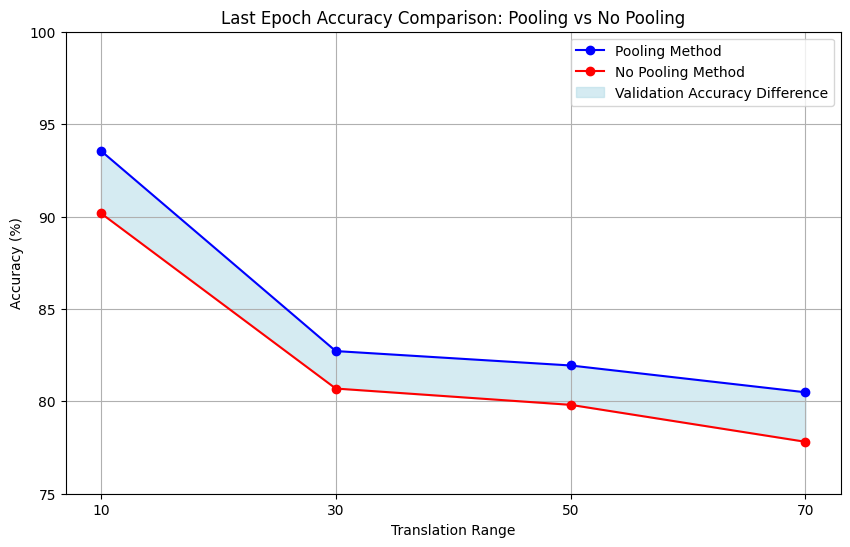

In [ ]:
import matplotlib.pyplot as plt

# Last epoch accuracies for pooling and no pooling methods across translations
translations = [10, 30, 50, 70]
pooling_accuracies = [93.56, 82.72, 81.94, 80.49]  # Last epoch accuracies for pooling method
no_pooling_accuracies = [90.18, 80.692, 79.81, 77.81]  # Last epoch accuracies for no pooling method

# Calculate the difference in last epoch accuracy between pooling and no pooling
accuracy_differences = [pooling_accuracies[i] - no_pooling_accuracies[i] for i in range(len(translations))]

# Plotting both pooling and no pooling accuracies
plt.figure(figsize=(10, 6))
plt.plot(translations, pooling_accuracies, marker='o', color='b', linestyle='-', label='Pooling Method')
plt.plot(translations, no_pooling_accuracies, marker='o', color='r', linestyle='-', label='No Pooling Method')

# Highlighting the differences
plt.fill_between(translations, pooling_accuracies, no_pooling_accuracies,
                 where=[p > n for p, n in zip(pooling_accuracies, no_pooling_accuracies)],
                 interpolate=True, color='lightblue', alpha=0.5, label='Validation Accuracy Difference')

plt.title('Last Epoch Accuracy Comparison: Pooling vs No Pooling')
plt.xlabel('Translation Range')
plt.ylabel('Accuracy (%)')
plt.xticks(translations)
plt.ylim(75,100)
plt.grid(True)
plt.legend()
plt.show()


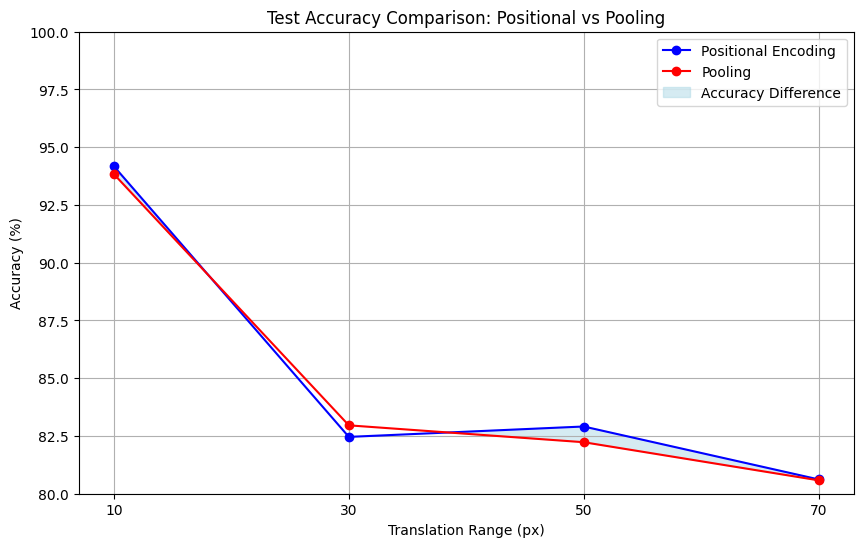

In [ ]:
import matplotlib.pyplot as plt

translations = [10, 30, 50, 70]
positional_accuracies = [94.17, 82.46, 82.91, 80.62] # Test accuracies for Positional Encoding
pooling_accuracies = [93.83, 82.96, 82.23, 80.58]    # Test accuracies for Pooling

# Plotting both Positional and Pooling accuracies
plt.figure(figsize=(10, 6))
plt.plot(translations, positional_accuracies, marker='o', color='b', linestyle='-', label='Positional Encoding')
plt.plot(translations, pooling_accuracies, marker='o', color='r', linestyle='-', label='Pooling')

# Highlighting the area between Positional and Pooling accuracies
plt.fill_between(translations, positional_accuracies, pooling_accuracies,
                 where=[p > n for n, p in zip(pooling_accuracies, positional_accuracies)],
                 interpolate=True, color='lightblue', alpha=0.5, label='Accuracy Difference')

plt.title('Test Accuracy Comparison: Positional vs Pooling')
plt.xlabel('Translation Range (px)')
plt.ylabel('Accuracy (%)')
plt.xticks(translations)
plt.ylim(80, 100)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
! pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.5/816.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Successfully uninstalled traitlets-5.7.1
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.24.0 which is incompatible.


In [ ]:
import dill

dill.load_session("/content/session_state5.pkl")

ModuleNotFoundError: No module named 'IPython.core.display_functions'

In [ ]:
! pip3 install IPython

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.relu(out)

        return out


class ResNetEncoder(nn.Module):
    def __init__(self, block, desired_layers, num_classes, use_global_pooling=True, learning_rate=0.001, epochs=45, patience_stop=4, weight_decay=1e-4, fourier_encoder_cls=None, laplacian_encoder_cls=None, positional_encoding_cls=None):
        super(ResNetEncoder, self).__init__()
        self.in_channels = 3
        self.block = block
        self.num_classes = num_classes
        self.use_global_pooling = use_global_pooling
        self.num_classes = num_classes

        self.learning_rate = learning_rate
        self.epochs = epochs
        self.patience_stop = patience_stop
        self.weight_decay = weight_decay

        self.fourier_encoder_cls = fourier_encoder_cls
        self.laplacian_encoder_cls = laplacian_encoder_cls
        self.positional_encoding_cls = positional_encoding_cls

        self.layers = nn.ModuleList()
        for i, layer_blocks in enumerate(desired_layers):
            stride = 2 if i > 0 else 1
            res_block = self.make_layer(self.block, 64 * (2 ** i), layer_blocks, stride)
            self.layers.append(res_block)

        self.use_global_pooling = self.use_global_pooling

        if self.use_global_pooling:
            self.global_pool = nn.AdaptiveAvgPool2d(1)

        final_out_channels = 64 * (2 ** (len(desired_layers) - 1))
        print(final_out_channels)
        if laplacian_encoder_cls is not None:
            self.laplacian_encoder = self.laplacian_encoder_cls(out_channels=final_out_channels)

        if fourier_encoder_cls is not None:
            self.fourier_encoder = self.fourier_encoder_cls()

        if positional_encoding_cls is not None:
            self.positional_encoder = positional_encoding_cls(num_channels=final_out_channels)

        fc_input_size = 64 * (2 ** (len(desired_layers) - 1))

        if not self.use_global_pooling:
            fc_input_size *= 4*4

        self.fc = nn.Linear(fc_input_size, self.num_classes)


        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=2, verbose=True)


    def make_layer(self, block, out_channels, blocks, stride):
        layer = []
        layer.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layer.append(block(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        if hasattr(self, 'fourier_encoder'):
            fourier_encoding = self.fourier_encoder(x)
            x = x + fourier_encoding

        if hasattr(self, 'laplacian_encoder'):
            x = x + self.laplacian_encoder(x)

        if hasattr(self, 'positional_encoder'):
            x = self.positional_encoder(x)

        if self.use_global_pooling:
            x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def fit(self, train_loader, val_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.criterion = nn.CrossEntropyLoss()

        best_val_loss = float('inf')
        best_val_accuracy = 0.0
        best_model_state = None
        patience_counter = 0

        training_results = {'train_accuracy': [], 'train_loss': [], 'val_accuracy': [], 'val_loss': []}

        for epoch in range(self.epochs):
            self.train()
            total_loss = 0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)

                # Applying weight decay
                for param in self.parameters():
                    loss += 1e-4 * torch.norm(param)

                loss.backward()

                # Gradient clipping to avoid exploding gradients
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            average_loss = total_loss / len(train_loader)
            accuracy = correct_predictions / total_samples * 100.0
            training_results['train_accuracy'].append(accuracy)
            training_results['train_loss'].append(average_loss)

            # Validation
            self.eval()
            val_loss = 0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    val_loss += self.criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_predictions += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)

            val_average_loss = val_loss / len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples * 100.0
            training_results['val_accuracy'].append(val_accuracy)
            training_results['val_loss'].append(val_average_loss)

            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.2f}%, "
                f"Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            # Learning rate scheduling based on validation loss
            self.scheduler.step(val_average_loss)

            # Update best validation accuracy and model state
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = self.state_dict()

            # # Early stopping based on validation loss
            # if val_average_loss < best_val_loss:
            #     best_val_loss = val_average_loss
            #     patience_counter = 0
            # else:
            #     patience_counter += 1

            # if patience_counter >= self.patience_stop:
            #     print(f"Early stopping at epoch {epoch + 1} as validation loss didn't improve for {self.patience_stop} epochs.")
            #     break

        # Restore the model state with the best validation accuracy
        if best_model_state is not None:
            self.load_state_dict(best_model_state)

        return training_results

    def predict(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()

        predictions = []
        with torch.no_grad():
            for inputs in test_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return predictions


In [9]:
from torchvision.datasets import CIFAR10
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np


resnet = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=True, epochs=45)

512


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [4]:
from torchsummary import summary
summary(resnet, (3,32,32), 32, 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4           [32, 64, 32, 32]          36,864
       BatchNorm2d-5           [32, 64, 32, 32]             128
              ReLU-6           [32, 64, 32, 32]               0
        BasicBlock-7           [32, 64, 32, 32]               0
            Conv2d-8          [32, 128, 16, 16]          73,728
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,456
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
       BasicBlock-14          [32, 128,

In [5]:
print(sum(p.numel() for p in resnet.parameters()))


4692426


In [6]:
!pip install torchprofile

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [7]:
import torch
from torchprofile import profile_macs
import torchvision.models as models

input = torch.randn(1, 3, 32, 32)  # Example input size

macs = profile_macs(resnet, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops}")

FLOPs: 419277824


In [12]:
import torch
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 32, 32, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 3.579787 ms, Std: 0.454641 ms, Mean Inference Time per Image: 0.111868 ms
Batch Size: 64 - Mean Inference Time for the Batch: 6.089669 ms, Std: 0.080818 ms, Mean Inference Time per Image: 0.095151 ms


In [3]:
import torch

input_data = torch.randn(1, 3, 32, 32).cuda()
resnet.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 27323904 bytes
Max Memory Allocated: 46198272 bytes


In [2]:
resnet_no_pooling = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=False, epochs=45)

512


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [4]:
from torchsummary import summary
summary(resnet_no_pooling, (3,32,32), 32, 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4           [32, 64, 32, 32]          36,864
       BatchNorm2d-5           [32, 64, 32, 32]             128
              ReLU-6           [32, 64, 32, 32]               0
        BasicBlock-7           [32, 64, 32, 32]               0
            Conv2d-8          [32, 128, 16, 16]          73,728
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,456
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
       BasicBlock-14          [32, 128,

In [5]:
print(sum(p.numel() for p in resnet_no_pooling.parameters()))


4769226


In [6]:
import torch
from torchprofile import profile_macs
import torchvision.models as models

input = torch.randn(1, 3, 32, 32)  # Example input size

macs = profile_macs(resnet_no_pooling, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops}")

FLOPs: 419430400


In [14]:
import torch
import time
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_no_pooling.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 32, 32, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_no_pooling(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_no_pooling(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")


Batch Size: 32 - Mean Inference Time for the Batch: 3.843709 ms, Std: 0.495782 ms, Mean Inference Time per Image: 0.120116 ms
Batch Size: 64 - Mean Inference Time for the Batch: 6.550702 ms, Std: 0.147573 ms, Mean Inference Time per Image: 0.102355 ms


In [3]:
import torch

input_data = torch.randn(1, 3, 32, 32).cuda()
resnet_no_pooling.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_no_pooling(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 27631104 bytes
Max Memory Allocated: 46505472 bytes


In [5]:
class LaplacianEncodingLayer(nn.Module):
    def __init__(self, out_channels):
        super(LaplacianEncodingLayer, self).__init__()
        self.laplacian_filter = torch.Tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]])
        self.out_channels = out_channels

    def forward(self, x):
        laplacian_filter = self.laplacian_filter.repeat(self.out_channels, 1, 1, 1).to(x.device)
        laplacian_encoding = F.conv2d(x, laplacian_filter, groups=x.size(1), padding=1)
        return laplacian_encoding
resnet_laplacian = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=True, epochs=45, laplacian_encoder_cls=LaplacianEncodingLayer)

512


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
print(sum(p.numel() for p in resnet_laplacian.parameters()))


4692426


In [7]:
import torch
import torch.nn.functional as F
from torchprofile import profile_macs
import torchvision.models as models
# Custom handler for aten::repeat
def handle_repeat(input, *args, **kwargs):
    # repeat is like expanding but involves creating new data, calculate based on output size
    output_shape = input.repeat(512,1,1,1).shape
    return torch.prod(torch.tensor(output_shape)).item()

input = torch.randn(1, 3, 32, 32)  # Example input size

macs = profile_macs(resnet_laplacian, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops + handle_repeat(input)}")

FLOPs: 420998144


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::repeat". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [14]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_laplacian.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 32, 32, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_laplacian(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_laplacian(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 3.952608 ms, Std: 1.847357 ms, Mean Inference Time per Image: 0.123519 ms
Batch Size: 64 - Mean Inference Time for the Batch: 6.330121 ms, Std: 0.699462 ms, Mean Inference Time per Image: 0.098908 ms


In [ ]:
import torch

input_data = torch.randn(1, 3, 32, 32).cuda()
resnet_laplacian.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_laplacian(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 27336192 bytes
Max Memory Allocated: 54730240 bytes


In [2]:
class FourierEncodingLayer(nn.Module):
    def __init__(self):
        super(FourierEncodingLayer, self).__init__()

    def forward(self, x):
        fft_result = torch.fft.fftn(x, dim=(-2, -1))  # Apply FFT on spatial dimensions

        real_part = torch.real(fft_result)
        return real_part
resnet_fourier = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=True, epochs=45, fourier_encoder_cls=FourierEncodingLayer)


512


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [3]:
print(sum(p.numel() for p in resnet_fourier.parameters()))


4692426


In [5]:
import torch
import torch.nn.functional as F
from torchprofile import profile_macs
import torchvision.models as models

def handle_fft_fftn(input, *args, **kwargs):
    # Assuming the complexity of FFT is O(NlogN), where N is the number of points
    input_size = input.size()
    num_elements = input.numel()
    flops = num_elements * (input_size[-1].bit_length() - 1)  # log2(N) for N elements
    return flops

def handle_real(input):
    # The real operation is simple and doesn't add significant FLOPs
    return input.numel()


input = torch.randn(1, 3, 32, 32)  # Example input size
macs = profile_macs(resnet_fourier, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops+ handle_fft_fftn(input)+ handle_real(input)}")

FLOPs: 419296256


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::fft_fftn". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::real". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [7]:
import torch
import time
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_fourier.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 32, 32, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_fourier(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_fourier(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 3.640376 ms, Std: 0.582545 ms, Mean Inference Time per Image: 0.113762 ms
Batch Size: 64 - Mean Inference Time for the Batch: 6.106230 ms, Std: 0.184256 ms, Mean Inference Time per Image: 0.095410 ms


In [8]:
import torch

input_data = torch.randn(1, 3, 32, 32).cuda()
resnet_fourier.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_fourier(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 27323904 bytes
Max Memory Allocated: 53671424 bytes


In [13]:
import math
import torch
import torch.nn as nn
import numpy as np

class PositionalEncodingLayer(nn.Module):
    def __init__(self, num_channels):
        """
        Initialize the PositionalEncodingLayer module.

        :param channels: The number of channels in the input tensor (e.g., 3 for RGB images).
        """
        super(PositionalEncodingLayer, self).__init__()
        self.org_channels = num_channels
        num_channels = int(np.ceil(num_channels / 4) * 2)
        self.num_channels = num_channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, num_channels, 2).float() / num_channels))
        self.register_buffer("inv_freq", inv_freq)
        self.register_buffer("cached_penc", None, persistent=False)

    def forward(self, tensor):
        """
        Apply positional encoding to a 4D tensor (batch_size, x, y, channels).

        :param tensor: Input tensor of size (batch_size, x, y, channels).
        :return: Positional encoding matrix of size (batch_size, x, y, channels).
        """
        if len(tensor.shape) != 4:
            raise RuntimeError("The input tensor must be 4D (batch_size, x, y, channels)!")

        # if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
        #     return self.cached_penc

        batch_size, x, y, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device, dtype=self.inv_freq.dtype)
        pos_y = torch.arange(y, device=tensor.device, dtype=self.inv_freq.dtype)
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        emb_x = self.get_emb(sin_inp_x).unsqueeze(1)
        emb_y = self.get_emb(sin_inp_y)
        emb = torch.zeros((x, y, self.num_channels * 2), device=tensor.device, dtype=tensor.dtype)
        emb[:, :, :self.num_channels] = emb_x
        emb[:, :, self.num_channels:2 * self.num_channels] = emb_y

        self.cached_penc = emb[None, :, :, :orig_ch].repeat(batch_size, 1, 1, 1)
        return tensor + self.cached_penc

    def get_emb(self, sin_inp):
        """
        Gets a base embedding for one dimension with sin and cos intertwined
        """
        emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
        return torch.flatten(emb, -2, -1)

resnet_positional = ResNetEncoder(BasicBlock, [1,1,1,1], num_classes=10, use_global_pooling=True, positional_encoding_cls=PositionalEncodingLayer)

512


In [ ]:
print(sum(p.numel() for p in resnet_positional.parameters()))

4692426


In [ ]:
import torch
import torch.nn.functional as F
from torchprofile import profile_macs
import torchvision.models as models

# Custom handler for aten::scalarimplicit
def handle_scalarimplicit(input):
    # This operation is often a no-op in terms of FLOPs
    return 0

# Custom handler for aten::arange
def handle_arange(*args, **kwargs):
    # arange creates a tensor, minimal FLOPs
    return 0

# Custom handler for aten::einsum
def handle_einsum(*args, **kwargs):
    # Approximate FLOPs for einsum
    input_shapes = [arg.shape for arg in args if isinstance(arg, torch.Tensor)]
    flops = 1
    for shape in input_shapes:
        flops *= torch.prod(torch.tensor(shape)).item()
    return flops

# Custom handler for aten::sin
def handle_sin(input):
    # Each sin operation is one FLOP per element
    return input.numel()

# Custom handler for aten::cos
def handle_cos(input):
    # Each cos operation is one FLOP per element
    return input.numel()

# Custom handler for aten::unsqueeze
def handle_unsqueeze(input, *args, **kwargs):
    # unsqueeze is a view operation, no FLOPs
    return 0

# Custom handler for aten::expand
def handle_expand(input, *args, **kwargs):
    # expand is also a view operation, no FLOPs
    return 0

# Custom handler for aten::copy_
def handle_copy_(input, *args, **kwargs):
    # copy_ operation is one FLOP per element
    return input.numel()

# Custom handler for aten::repeat
def handle_repeat(input, *args, **kwargs):
    # repeat is like expanding but involves creating new data, calculate based on output size
    output_shape = input.repeat(32,1,1,1).shape
    return torch.prod(torch.tensor(output_shape)).item()

input = torch.randn(1, 3, 32, 32)  # Example input size

macs = profile_macs(resnet_positional, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops +handle_einsum(input) + handle_sin(input) + handle_cos(input)+ handle_copy_(input)+ handle_repeat(input)}")

FLOPs: 419388416


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::scalarimplicit". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::arange". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::einsum". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sin". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::cos". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserW

In [16]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 32, 32, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 3.678517 ms, Std: 0.543875 ms, Mean Inference Time per Image: 0.114954 ms
Batch Size: 64 - Mean Inference Time for the Batch: 6.051284 ms, Std: 0.113092 ms, Mean Inference Time per Image: 0.094551 ms


In [ ]:
import torch

input_data = torch.randn(1, 3, 32, 32).cuda()
resnet_positional.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_positional(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 27369472 bytes
Max Memory Allocated: 54763520 bytes


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

from torch.optim.lr_scheduler import ReduceLROnPlateau


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetEncoder(nn.Module):
    def __init__(self, block, desired_layers, num_classes, use_global_pooling=True, learning_rate=0.0001, epochs=20, patience_stop=6, weight_decay=1e-4, max_grad_norm=None, fourier_encoder_cls=None, laplacian_encoder_cls=None, positional_encoding_cls=None):
        super(ResNetEncoder, self).__init__()
        self.block = block
        self.num_classes = num_classes
        self.use_global_pooling = use_global_pooling
        self.num_classes = num_classes

        self.learning_rate = learning_rate
        self.epochs = epochs
        self.patience_stop = patience_stop
        self.weight_decay = weight_decay
        self.max_grad_norm = max_grad_norm

        self.fourier_encoder_cls = fourier_encoder_cls
        self.laplacian_encoder_cls = laplacian_encoder_cls
        self.positional_encoding_cls = positional_encoding_cls



        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layers = nn.ModuleList()
        for i, layer_blocks in enumerate(desired_layers):
            stride = 2 if i > 0 else 1
            res_block = self.make_layer(self.block, 64 * (2 ** i), layer_blocks, stride)
            self.layers.append(res_block)

        self.use_global_pooling = self.use_global_pooling

        if self.use_global_pooling:
            self.global_pool = nn.AdaptiveAvgPool2d(1)

        final_out_channels = 64 * (2 ** (len(desired_layers) - 1))
        print(final_out_channels)
        if laplacian_encoder_cls is not None:
            self.laplacian_encoder = self.laplacian_encoder_cls(out_channels=final_out_channels)

        if fourier_encoder_cls is not None:
            self.fourier_encoder = self.fourier_encoder_cls()

        if positional_encoding_cls is not None:
            self.positional_encoder = positional_encoding_cls(num_channels=final_out_channels)


        fc_input_size = 64 * (2 ** (len(desired_layers) - 1))

        if not self.use_global_pooling:
            fc_input_size *= 4*4

        self.fc = nn.Linear(fc_input_size, self.num_classes)


        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=4, verbose=True)


    def make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layer = []
        layer.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layer.append(block(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layer)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for layer in self.layers:
            x = layer(x)

        if hasattr(self, 'fourier_encoder'):
            fourier_encoding = self.fourier_encoder(x)
            x = x + fourier_encoding

        if hasattr(self, 'laplacian_encoder'):
            x = x + self.laplacian_encoder(x)

        if hasattr(self, 'positional_encoder'):
            x = self.positional_encoder(x)


        if self.use_global_pooling:
            x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def fit(self, train_loader, val_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.criterion = nn.CrossEntropyLoss()

        best_val_loss = float('inf')
        best_val_accuracy = 0.0
        best_model_state = None
        patience_counter = 0

        training_results = {'train_accuracy': [], 'train_loss': [], 'val_accuracy': [], 'val_loss': []}

        for epoch in range(self.epochs):
            self.train()
            total_loss = 0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)

                # # Applying weight decay
                # for param in self.parameters():
                #     loss += 1e-4 * torch.norm(param)

                loss.backward()

                # Gradient clipping if max_grad_norm is specified
                if self.max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), self.max_grad_norm)

                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            average_loss = total_loss / len(train_loader)
            accuracy = correct_predictions / total_samples * 100.0
            training_results['train_accuracy'].append(accuracy)
            training_results['train_loss'].append(average_loss)

            # Validation
            self.eval()
            val_loss = 0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    val_loss += self.criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_predictions += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)

            val_average_loss = val_loss / len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples * 100.0
            training_results['val_accuracy'].append(val_accuracy)
            training_results['val_loss'].append(val_average_loss)

            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.2f}%, "
                f"Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            # Learning rate scheduling based on validation loss
            self.scheduler.step(val_average_loss)

            # Update best validation accuracy and model state
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = self.state_dict()

            # Early stopping based on validation loss
            if val_average_loss < best_val_loss:
                best_val_loss = val_average_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience_stop:
                print(f"Early stopping at epoch {epoch + 1} as validation loss didn't improve for {self.patience_stop} epochs.")
                break

        # Restore the model state with the best validation accuracy
        if best_model_state is not None:
            self.load_state_dict(best_model_state)

        return training_results

    def predict(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()

        predictions = []
        with torch.no_grad():
            for inputs in test_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return predictions


In [18]:
resnet_model_with_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 1, 1], num_classes=3, use_global_pooling=True)


1024


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
from torchsummary import summary

summary(resnet_model_with_pooling, (3,224,224), 32, 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [ ]:
print(sum(p.numel() for p in resnet_model_with_pooling.parameters()))


21145155


In [ ]:
import torch
from torchprofile import profile_macs
import torchvision.models as models

input = torch.randn(1, 3, 224, 224)  # Example input size

macs = profile_macs(resnet_model_with_pooling, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops}")

FLOPs: 3639436288


In [23]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model_with_pooling.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 224, 224, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_model_with_pooling(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_model_with_pooling(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 31.338004 ms, Std: 0.324485 ms, Mean Inference Time per Image: 0.979313 ms
Batch Size: 64 - Mean Inference Time for the Batch: 58.799663 ms, Std: 1.244454 ms, Mean Inference Time per Image: 0.918745 ms


In [ ]:
import torch

input_data = torch.randn(1, 3, 224, 224).cuda()
resnet_model_with_pooling.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_model_with_pooling(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 93773824 bytes
Max Memory Allocated: 198866944 bytes


In [25]:
resnet_model_without_pooling = ResNetEncoder(BasicBlock, [2, 2, 2, 1, 1], num_classes=3, use_global_pooling=False)


1024


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
from torchsummary import summary

summary(resnet_model_without_pooling, (3,224,224), 32, 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [ ]:
print(sum(p.numel() for p in resnet_model_without_pooling.parameters()))


21191235


In [ ]:
import torch
from torchprofile import profile_macs
import torchvision.models as models

input = torch.randn(1, 3, 224, 224)  # Example input size

macs = profile_macs(resnet_model_without_pooling, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops}")

FLOPs: 3639526400


In [28]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model_without_pooling.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 224, 224, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_model_without_pooling(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_model_without_pooling(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 32.091889 ms, Std: 3.746856 ms, Mean Inference Time per Image: 1.002872 ms
Batch Size: 64 - Mean Inference Time for the Batch: 59.552708 ms, Std: 1.299084 ms, Mean Inference Time per Image: 0.930511 ms


In [ ]:
import torch

input_data = torch.randn(1, 3, 224, 224).cuda()
resnet_model_without_pooling.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_model_without_pooling(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 94560256 bytes
Max Memory Allocated: 199653376 bytes


In [29]:

class LaplacianEncodingLayer(nn.Module):
    def __init__(self, out_channels):
        super(LaplacianEncodingLayer, self).__init__()
        self.laplacian_filter = torch.Tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]])
        self.out_channels = out_channels

    def forward(self, x):
        laplacian_filter = self.laplacian_filter.repeat(self.out_channels, 1, 1, 1).to(x.device)
        laplacian_encoding = F.conv2d(x, laplacian_filter, groups=x.size(1), padding=1)
        return laplacian_encoding
resnet_model_with_laplacian = ResNetEncoder(BasicBlock, [2, 2, 2, 1, 1], num_classes=3, use_global_pooling=True, laplacian_encoder_cls=LaplacianEncodingLayer)


1024


In [ ]:
print(sum(p.numel() for p in resnet_model_with_laplacian.parameters()))


21145155


In [ ]:
summary(resnet_model_with_laplacian, (3,224,224), 32, 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [ ]:
from torchprofile import profile_macs
import torchvision.models as models

# Custom handler for aten::repeat
def handle_repeat(input, *args, **kwargs):
    # repeat is like expanding but involves creating new data, calculate based on output size
    output_shape = input.repeat(1024,1,1,1).shape
    return torch.prod(torch.tensor(output_shape)).item()

input = torch.randn(1, 3, 224, 224)  # Example input size

macs = profile_macs(resnet_model_with_laplacian, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops+ handle_repeat(input)}")

/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::repeat". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


FLOPs: 3793871872


In [36]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model_with_laplacian.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 224, 224, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_model_with_laplacian(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_model_with_laplacian(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 32.257253 ms, Std: 0.644273 ms, Mean Inference Time per Image: 1.008039 ms
Batch Size: 64 - Mean Inference Time for the Batch: 59.482971 ms, Std: 1.398122 ms, Mean Inference Time per Image: 0.929421 ms


In [ ]:
import torch

input_data = torch.randn(1, 3, 224, 224).cuda()
resnet_model_with_laplacian.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_model_with_laplacian(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 94375936 bytes
Max Memory Allocated: 199469056 bytes


In [34]:
import torch
import torch.nn as nn

class FourierEncodingLayer(nn.Module):
    def __init__(self):
        super(FourierEncodingLayer, self).__init__()

    def forward(self, x):
        fft_result = torch.fft.fftn(x, dim=(-2, -1))  # Apply FFT on spatial dimensions

        real_part = torch.real(fft_result)
        return real_part
resnet_model_with_fourier = ResNetEncoder(BasicBlock, [2, 2, 2, 1, 1], num_classes=3, use_global_pooling=True, fourier_encoder_cls=FourierEncodingLayer)


1024


In [ ]:
print(sum(p.numel() for p in resnet_model_with_fourier.parameters()))


21145155


In [ ]:
from torchprofile import profile_macs
import torchvision.models as models
def handle_fft_fftn(input, *args, **kwargs):
    # Assuming the complexity of FFT is O(NlogN), where N is the number of points
    input_size = input.size()
    num_elements = input.numel()
    flops = num_elements * (input_size[-1].bit_length() - 1)  # log2(N) for N elements
    return flops

def handle_real(input):
    # The real operation is simple and doesn't add significant FLOPs
    return input.numel()

input = torch.randn(1, 3, 224, 224)  # Example input size

macs = profile_macs(resnet_model_with_fourier, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops + handle_fft_fftn(input) + handle_real(input)}")

FLOPs: 3640640512


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::fft_fftn". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::real". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [40]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model_with_fourier.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 224, 224, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_model_with_fourier(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_model_with_fourier(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 31.525147 ms, Std: 0.496445 ms, Mean Inference Time per Image: 0.985161 ms
Batch Size: 64 - Mean Inference Time for the Batch: 59.056114 ms, Std: 1.115145 ms, Mean Inference Time per Image: 0.922752 ms


In [ ]:
import torch

input_data = torch.randn(1, 3, 224, 224).cuda()
resnet_model_with_fourier.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_model_with_fourier(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 94375936 bytes
Max Memory Allocated: 199469056 bytes


In [ ]:
summary(resnet_model_with_fourier, (3,224,224), 32, 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [41]:
import math
import torch
import torch.nn as nn
import numpy as np

class PositionalEncodingLayer(nn.Module):
    def __init__(self, num_channels):
        """
        Initialize the PositionalEncodingLayer module.

        :param channels: The number of channels in the input tensor (e.g., 3 for RGB images).
        """
        super(PositionalEncodingLayer, self).__init__()
        self.org_channels = num_channels
        num_channels = int(np.ceil(num_channels / 4) * 2)
        self.num_channels = num_channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, num_channels, 2).float() / num_channels))
        self.register_buffer("inv_freq", inv_freq)
        self.register_buffer("cached_penc", None, persistent=False)

    def forward(self, tensor):
        """
        Apply positional encoding to a 4D tensor (batch_size, x, y, channels).

        :param tensor: Input tensor of size (batch_size, x, y, channels).
        :return: Positional encoding matrix of size (batch_size, x, y, channels).
        """
        if len(tensor.shape) != 4:
            raise RuntimeError("The input tensor must be 4D (batch_size, x, y, channels)!")

        # if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
        #     return self.cached_penc

        batch_size, x, y, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device, dtype=self.inv_freq.dtype)
        pos_y = torch.arange(y, device=tensor.device, dtype=self.inv_freq.dtype)
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        emb_x = self.get_emb(sin_inp_x).unsqueeze(1)
        emb_y = self.get_emb(sin_inp_y)
        emb = torch.zeros((x, y, self.num_channels * 2), device=tensor.device, dtype=tensor.dtype)
        emb[:, :, :self.num_channels] = emb_x
        emb[:, :, self.num_channels:2 * self.num_channels] = emb_y

        self.cached_penc = emb[None, :, :, :orig_ch].repeat(batch_size, 1, 1, 1)
        return tensor + self.cached_penc

    def get_emb(self, sin_inp):
        """
        Gets a base embedding for one dimension with sin and cos intertwined
        """
        emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
        return torch.flatten(emb, -2, -1)

resnet_model_with_positional = ResNetEncoder(BasicBlock, [2, 2, 2, 1, 1], num_classes=3, use_global_pooling=True, positional_encoding_cls=PositionalEncodingLayer)

1024


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
print(sum(p.numel() for p in resnet_model_with_positional.parameters()))


21145155


In [ ]:
import torch
import torch.nn.functional as F
from torchprofile import profile_macs
import torchvision.models as models

# Custom handler for aten::scalarimplicit
def handle_scalarimplicit(input):
    # This operation is often a no-op in terms of FLOPs
    return 0

# Custom handler for aten::arange
def handle_arange(*args, **kwargs):
    # arange creates a tensor, minimal FLOPs
    return 0

# Custom handler for aten::einsum
def handle_einsum(*args, **kwargs):
    # Approximate FLOPs for einsum
    input_shapes = [arg.shape for arg in args if isinstance(arg, torch.Tensor)]
    flops = 1
    for shape in input_shapes:
        flops *= torch.prod(torch.tensor(shape)).item()
    return flops

# Custom handler for aten::sin
def handle_sin(input):
    # Each sin operation is one FLOP per element
    return input.numel()

# Custom handler for aten::cos
def handle_cos(input):
    # Each cos operation is one FLOP per element
    return input.numel()

# Custom handler for aten::unsqueeze
def handle_unsqueeze(input, *args, **kwargs):
    # unsqueeze is a view operation, no FLOPs
    return 0

# Custom handler for aten::expand
def handle_expand(input, *args, **kwargs):
    # expand is also a view operation, no FLOPs
    return 0

# Custom handler for aten::copy_
def handle_copy_(input, *args, **kwargs):
    # copy_ operation is one FLOP per element
    return input.numel()

# Custom handler for aten::repeat
def handle_repeat(input, *args, **kwargs):
    # repeat is like expanding but involves creating new data, calculate based on output size
    output_shape = input.repeat(32,1,1,1).shape
    return torch.prod(torch.tensor(output_shape)).item()

input = torch.randn(1, 3, 224, 224)  # Example input size

macs = profile_macs(resnet_model_with_positional, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops +handle_einsum(input) + handle_sin(input) + handle_cos(input)+ handle_copy_(input)+ handle_repeat(input)}")

FLOPs: 3644855296


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::scalarimplicit". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::arange". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::einsum". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::sin". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::cos". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserW

In [43]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model_with_positional.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 224, 224, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_model_with_positional(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_model_with_positional(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 31.438958 ms, Std: 0.372857 ms, Mean Inference Time per Image: 0.982467 ms
Batch Size: 64 - Mean Inference Time for the Batch: 61.518701 ms, Std: 1.900933 ms, Mean Inference Time per Image: 0.961230 ms


In [ ]:
import torch

input_data = torch.randn(1, 3, 224, 224).cuda()
resnet_model_with_positional.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_model_with_positional(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 94442496 bytes
Max Memory Allocated: 199535616 bytes


In [ ]:
summary(resnet_model_with_positional, (3,224,224), 32, 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class AttentionPooling(nn.Module):
    def __init__(self, in_channels):
        super(AttentionPooling, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // 2, in_channels),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        attention_scores = self.fc(y)
        weighted_features = (x * attention_scores.view(b, c, 1, 1)).sum(dim=(2, 3))
        return weighted_features


class ResNetEncoder(nn.Module):
    def __init__(self, block, desired_layers, num_classes, use_global_pooling=True, learning_rate=0.0001, epochs=20, patience_stop=6, weight_decay=1e-4, max_grad_norm=None, fourier_encoder_cls=None, laplacian_encoder_cls=None, positional_encoding_cls=None):
        super(ResNetEncoder, self).__init__()
        self.block = block
        self.num_classes = num_classes
        self.use_global_pooling = use_global_pooling
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.patience_stop = patience_stop
        self.weight_decay = weight_decay
        self.max_grad_norm = max_grad_norm

        self.fourier_encoder_cls = fourier_encoder_cls
        self.laplacian_encoder_cls = laplacian_encoder_cls
        self.positional_encoding_cls = positional_encoding_cls

        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layers = nn.ModuleList()
        for i, layer_blocks in enumerate(desired_layers):
            stride = 2 if i > 0 else 1
            res_block = self.make_layer(self.block, 64 * (2 ** i), layer_blocks, stride)
            self.layers.append(res_block)

        final_out_channels = 64 * (2 ** (len(desired_layers) - 1))

        if laplacian_encoder_cls is not None:
            self.laplacian_encoder = self.laplacian_encoder_cls(out_channels=final_out_channels)

        if fourier_encoder_cls is not None:
            self.fourier_encoder = self.fourier_encoder_cls()

        if positional_encoding_cls is not None:
            self.positional_encoder = positional_encoding_cls(num_channels=final_out_channels)

        if self.use_global_pooling:
            self.attention_pooling = AttentionPooling(final_out_channels)
            fc_input_size = final_out_channels
        else:
            fc_input_size = final_out_channels * 4 * 4

        self.fc = nn.Linear(fc_input_size, self.num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=4, verbose=True)

    def make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layer = []
        layer.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layer.append(block(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layer)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for layer in self.layers:
            x = layer(x)

        if hasattr(self, 'fourier_encoder'):
            fourier_encoding = self.fourier_encoder(x)
            x = x + fourier_encoding

        if hasattr(self, 'laplacian_encoder'):
            x = x + self.laplacian_encoder(x)

        if hasattr(self, 'positional_encoder'):
            x = self.positional_encoder(x)

        if self.use_global_pooling:
            x = self.attention_pooling(x)
        else:
            x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x

    def fit(self, train_loader, val_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.criterion = nn.CrossEntropyLoss()

        best_val_loss = float('inf')
        best_val_accuracy = 0.0
        best_model_state = None
        patience_counter = 0

        training_results = {'train_accuracy': [], 'train_loss': [], 'val_accuracy': [], 'val_loss': []}

        for epoch in range(self.epochs):
            self.train()
            total_loss = 0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)

                loss.backward()

                if self.max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), self.max_grad_norm)

                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            average_loss = total_loss / len(train_loader)
            accuracy = correct_predictions / total_samples * 100.0
            training_results['train_accuracy'].append(accuracy)
            training_results['train_loss'].append(average_loss)

            self.eval()
            val_loss = 0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    val_loss += self.criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_predictions += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)

            val_average_loss = val_loss / len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples * 100.0
            training_results['val_accuracy'].append(val_accuracy)
            training_results['val_loss'].append(val_average_loss)

            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.2f}%, "
                  f"Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            self.scheduler.step(val_average_loss)

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = self.state_dict()

            if val_average_loss < best_val_loss:
                best_val_loss = val_average_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience_stop:
                print(f"Early stopping at epoch {epoch + 1} as validation loss didn't improve for {self.patience_stop} epochs.")
                break

        if best_model_state is not None:
            self.load_state_dict(best_model_state)

        return training_results

    def predict(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()

        predictions = []
        with torch.no_grad():
            for inputs in test_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return predictions

resnet_model_with_attention = ResNetEncoder(BasicBlock, [2, 2, 2, 1, 1], num_classes=3, use_global_pooling=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [52]:
print(sum(p.numel() for p in resnet_model_with_attention.parameters()))


22195267


In [53]:
import torch
import torch.nn.functional as F
from torchprofile import profile_macs
import torchvision.models as models

input = torch.randn(1, 3, 224, 224)  # Example input size

macs = profile_macs(resnet_model_with_attention, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops}")

FLOPs: 3641566208


In [56]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model_with_attention.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 224, 224, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_model_with_attention(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_model_with_attention(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Batch Size: 32 - Mean Inference Time for the Batch: 31.325818 ms, Std: 0.361262 ms, Mean Inference Time per Image: 0.978932 ms
Batch Size: 64 - Mean Inference Time for the Batch: 60.039828 ms, Std: 1.503238 ms, Mean Inference Time per Image: 0.938122 ms


In [48]:
import torch

input_data = torch.randn(1, 3, 224, 224).cuda()
resnet_model_with_attention.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_model_with_attention(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 562541056 bytes
Max Memory Allocated: 696824832 bytes


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

class AttentionPooling(nn.Module):
    def __init__(self, in_channels):
        super(AttentionPooling, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // 2, in_channels)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        b, c, h, w = x.size()
        y = x.view(b, c, -1)  # Flatten spatial dimensions
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        attention_scores = self.softmax(y)  # Compute attention scores
        attention_scores = attention_scores.view(b, c, h, w)
        weighted_features = (x * attention_scores).sum(dim=(2, 3))  # Weighted sum across spatial dimensions
        return weighted_features

class ResNetEncoder(nn.Module):
    def __init__(self, block, desired_layers, num_classes, use_global_pooling=True, learning_rate=0.001, epochs=45, patience_stop=4, weight_decay=1e-4, fourier_encoder_cls=None, laplacian_encoder_cls=None, positional_encoding_cls=None):
        super(ResNetEncoder, self).__init__()
        self.in_channels = 3
        self.block = block
        self.num_classes = num_classes
        self.use_global_pooling = use_global_pooling

        self.learning_rate = learning_rate
        self.epochs = epochs
        self.patience_stop = patience_stop
        self.weight_decay = weight_decay

        self.fourier_encoder_cls = fourier_encoder_cls
        self.laplacian_encoder_cls = laplacian_encoder_cls
        self.positional_encoding_cls = positional_encoding_cls

        self.layers = nn.ModuleList()
        for i, layer_blocks in enumerate(desired_layers):
            stride = 2 if i > 0 else 1
            res_block = self.make_layer(self.block, 64 * (2 ** i), layer_blocks, stride)
            self.layers.append(res_block)

        final_out_channels = 64 * (2 ** (len(desired_layers) - 1))

        if laplacian_encoder_cls is not None:
            self.laplacian_encoder = self.laplacian_encoder_cls(out_channels=final_out_channels)

        if fourier_encoder_cls is not None:
            self.fourier_encoder = self.fourier_encoder_cls()

        if positional_encoding_cls is not None:
            self.positional_encoder = positional_encoding_cls(num_channels=final_out_channels)

        if self.use_global_pooling:
            self.attention_pooling = AttentionPooling(final_out_channels)

        fc_input_size = final_out_channels

        self.fc = nn.Linear(fc_input_size, self.num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    def make_layer(self, block, out_channels, blocks, stride):
        layer = []
        layer.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layer.append(block(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        if hasattr(self, 'fourier_encoder'):
            fourier_encoding = self.fourier_encoder(x)
            x = x + fourier_encoding

        if hasattr(self, 'laplacian_encoder'):
            x = x + self.laplacian_encoder(x)

        if hasattr(self, 'positional_encoder'):
            x = self.positional_encoder(x)

        if self.use_global_pooling:
            x = self.attention_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def fit(self, train_loader, val_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.criterion = nn.CrossEntropyLoss()

        best_val_loss = float('inf')
        best_val_accuracy = 0.0
        best_model_state = None
        patience_counter = 0

        training_results = {'train_accuracy': [], 'train_loss': [], 'val_accuracy': [], 'val_loss': []}

        for epoch in range(self.epochs):
            self.train()
            total_loss = 0
            correct_predictions = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)

                # Applying weight decay
                for param in self.parameters():
                    loss += 1e-4 * torch.norm(param)

                loss.backward()

                # Gradient clipping to avoid exploding gradients
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            average_loss = total_loss / len(train_loader)
            accuracy = correct_predictions / total_samples * 100.0
            training_results['train_accuracy'].append(accuracy)
            training_results['train_loss'].append(average_loss)

            # Validation
            self.eval()
            val_loss = 0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    val_loss += self.criterion(outputs, labels).item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_predictions += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)

            val_average_loss = val_loss / len(val_loader)
            val_accuracy = val_correct_predictions / val_total_samples * 100.0
            training_results['val_accuracy'].append(val_accuracy)
            training_results['val_loss'].append(val_average_loss)

            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.2f}%, "
                f"Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

            # Learning rate scheduling based on validation loss
            self.scheduler.step(val_average_loss)

            # Update best validation accuracy and model state
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = self.state_dict()

            # Early stopping based on validation loss
            if val_average_loss < best_val_loss:
                best_val_loss = val_average_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience_stop:
                print(f"Early stopping at epoch {epoch + 1} as validation loss didn't improve for {self.patience_stop} epochs.")
                break

        # Restore the model state with the best validation accuracy
        if best_model_state is not None:
            self.load_state_dict(best_model_state)

        return training_results

    def predict(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()

        predictions = []
        with torch.no_grad():
            for inputs in test_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())

        return predictions

resnet_attention = ResNetEncoder(BasicBlock, [1, 1, 1, 1], num_classes=10, use_global_pooling=True)



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
from torchsummary import summary
summary(resnet_attention, (3,32,32), 32, 'cuda')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4           [32, 64, 32, 32]          36,864
       BatchNorm2d-5           [32, 64, 32, 32]             128
              ReLU-6           [32, 64, 32, 32]               0
        BasicBlock-7           [32, 64, 32, 32]               0
            Conv2d-8          [32, 128, 16, 16]          73,728
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,456
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
       BasicBlock-14          [32, 128,

In [ ]:
print(sum(p.numel() for p in resnet_attention.parameters()))


4955338


In [ ]:
import torch
import torch.nn.functional as F
from torchprofile import profile_macs
import torchvision.models as models

input = torch.randn(1, 3, 32, 32)  # Example input size

macs = profile_macs(resnet_attention, input)
flops = 2 * macs  # Convert MACs to FLOPs (1 MAC = 2 FLOPs)
print(f"FLOPs: {flops}")

FLOPs: 419818496


In [ ]:
import torch
import time
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_attention.to(device)
def measure_inference_time(batch_size, repetitions=300):
    dummy_input = torch.randn(batch_size, 3, 224, 224, dtype=torch.float).to(device)

    # Initialize loggers
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros((repetitions, 1))

    # GPU warm-up
    for _ in range(10):
        _ = resnet_attention(dummy_input)

    # Measure performance
    with torch.no_grad():
        for rep in range(repetitions):
            starter.record()
            _ = resnet_attention(dummy_input)
            ender.record()
            # Wait for GPU sync
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    mean_image_time = mean_syn / batch_size
    return mean_syn, std_syn, mean_image_time

# Test different batch sizes
batch_sizes = [32, 64]
results = {}

for batch_size in batch_sizes:
    mean_syn, std_syn, mean_image_time = measure_inference_time(batch_size)
    results[batch_size] = (mean_syn, std_syn, mean_image_time)
    print(f"Batch Size: {batch_size} - Mean Inference Time for the Batch: {mean_syn:.6f} ms, Std: {std_syn:.6f} ms, Mean Inference Time per Image: {mean_image_time:.6f} ms")

Inference Time: 0.01721978187561035 seconds


In [ ]:
import torch

input_data = torch.randn(1, 3, 32, 32).cuda()
resnet_attention.cuda()

torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    resnet_attention(input_data)
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated()} bytes")

Memory Allocated: 28387840 bytes
Max Memory Allocated: 55781888 bytes


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
!nvidia-smi

Wed May 29 21:35:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvidia-smi

Sun May 19 11:06:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0              29W /  70W |    235MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

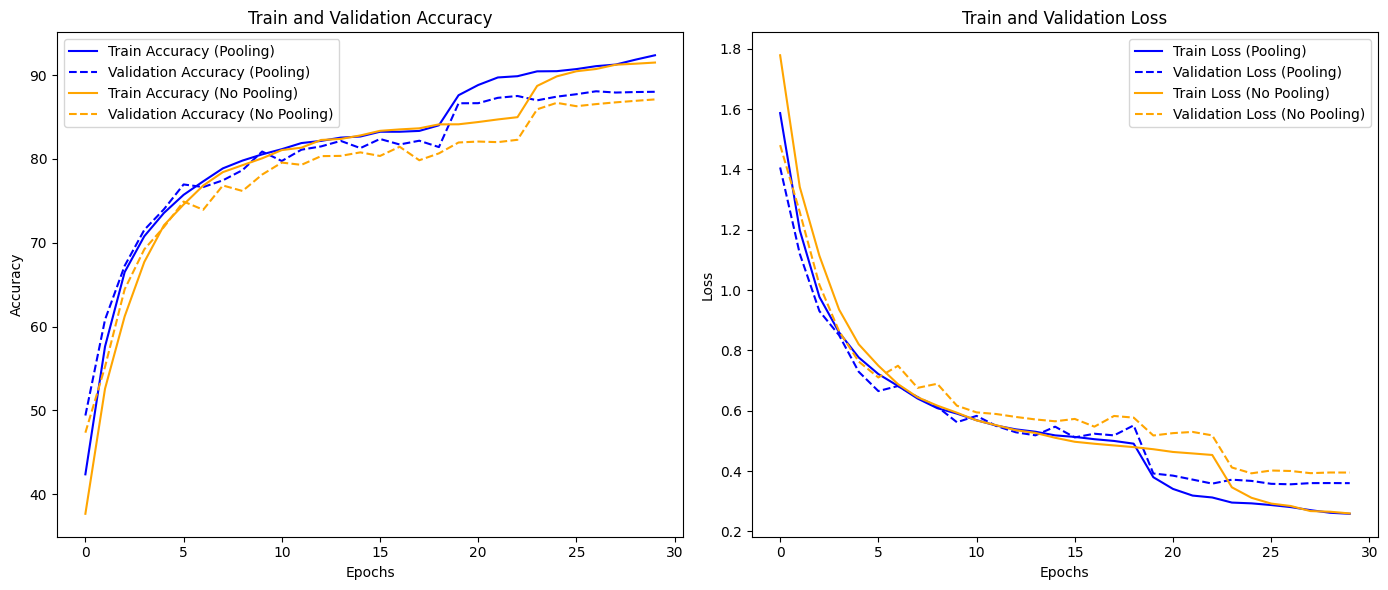

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = list(range(1, 31))

# With Pooling
pooling_train_loss = [1.5869, 1.1985, 0.9774, 0.8600, 0.7769, 0.7218, 0.6824, 0.6405, 0.6087, 0.5906, 0.5688, 0.5510, 0.5384, 0.5305, 0.5185, 0.5134, 0.5058, 0.5000, 0.4910, 0.3798, 0.3410, 0.3189, 0.3126, 0.2957, 0.2931, 0.2875, 0.2807, 0.2706, 0.2619, 0.2585]
pooling_train_accuracy = [42.36, 57.61, 66.50, 70.78, 73.56, 75.72, 77.33, 78.88, 79.81, 80.55, 81.17, 81.90, 82.16, 82.55, 82.68, 83.25, 83.25, 83.35, 84.02, 87.61, 88.83, 89.73, 89.88, 90.46, 90.48, 90.73, 91.08, 91.27, 91.85, 92.38]
pooling_val_loss = [1.4066, 1.1203, 0.9304, 0.8507, 0.7294, 0.6653, 0.6821, 0.6454, 0.6135, 0.5621, 0.5831, 0.5499, 0.5287, 0.5186, 0.5473, 0.5117, 0.5239, 0.5185, 0.5515, 0.3921, 0.3850, 0.3719, 0.3585, 0.3716, 0.3675, 0.3579, 0.3563, 0.3602, 0.3604, 0.3601]
pooling_val_accuracy = [49.38, 60.82, 67.25, 71.54, 74.00, 76.96, 76.65, 77.45, 78.67, 80.89, 79.76, 81.11, 81.50, 82.16, 81.30, 82.39, 81.73, 82.18, 81.42, 86.65, 86.66, 87.30, 87.52, 87.00, 87.44, 87.73, 88.08, 87.93, 87.99, 88.02]

# Without Pooling
no_pooling_train_loss = [1.7786, 1.3418, 1.1138, 0.9357, 0.8205, 0.7496, 0.6883, 0.6448, 0.6171, 0.5936, 0.5681, 0.5522, 0.5356, 0.5266, 0.5105, 0.4973, 0.4907, 0.4851, 0.4795, 0.4726, 0.4635, 0.4586, 0.4535, 0.3463, 0.3115, 0.2924, 0.2843, 0.2675, 0.2654, 0.2597]
no_pooling_train_accuracy = [37.65, 52.58, 61.21, 67.71, 72.09, 74.56, 76.83, 78.43, 79.26, 80.08, 81.06, 81.35, 82.27, 82.39, 82.81, 83.36, 83.53, 83.66, 84.13, 84.14, 84.41, 84.72, 84.99, 88.72, 89.86, 90.47, 90.74, 91.25, 91.37, 91.51]
no_pooling_val_loss = [1.4807, 1.2589, 1.0176, 0.8640, 0.7633, 0.7104, 0.7493, 0.6760, 0.6896, 0.6169, 0.5947, 0.5893, 0.5796, 0.5713, 0.5652, 0.5730, 0.5474, 0.5828, 0.5773, 0.5181, 0.5259, 0.5299, 0.5185, 0.4120, 0.3927, 0.4020, 0.4004, 0.3932, 0.3954, 0.3952]
no_pooling_val_accuracy = [47.33, 55.19, 64.45, 69.22, 71.88, 74.92, 73.94, 76.84, 76.18, 78.14, 79.57, 79.30, 80.34, 80.37, 80.79, 80.36, 81.46, 79.85, 80.67, 81.97, 82.08, 82.01, 82.29, 85.93, 86.70, 86.30, 86.55, 86.76, 86.94, 87.11]

# Plotting train and validation accuracy for both methods
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(pooling_train_accuracy, label='Train Accuracy (Pooling)', linestyle='-', color='blue')
plt.plot(pooling_val_accuracy, label='Validation Accuracy (Pooling)', linestyle='--', color='blue')
plt.plot(no_pooling_train_accuracy, label='Train Accuracy (No Pooling)', linestyle='-', color='orange')
plt.plot(no_pooling_val_accuracy, label='Validation Accuracy (No Pooling)', linestyle='--', color='orange')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting train and validation loss for both methods
plt.subplot(1, 2, 2)
plt.plot(pooling_train_loss, label='Train Loss (Pooling)', linestyle='-', color='blue')
plt.plot(pooling_val_loss, label='Validation Loss (Pooling)', linestyle='--', color='blue')
plt.plot(no_pooling_train_loss, label='Train Loss (No Pooling)', linestyle='-', color='orange')
plt.plot(no_pooling_val_loss, label='Validation Loss (No Pooling)', linestyle='--', color='orange')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [27]:
pooling_results_10 = {
    'train_accuracy': [
        57.312609265734274,
        70.1540646853147,
        79.63559877622379,
        86.98645104895105,
        90.93913898601399,
        93.52600524475524,
        94.81807255244755,
        95.80146416083916,
        96.2822333916084,
        96.99792395104895,
        97.09899475524476,
        97.34484265734265,
        97.60161713286713,
        97.81195367132867,
        97.88570804195804,
        98.046875,
        99.47552447552448,
        99.51923076923077,
        99.46186625874127,
        99.4454763986014
    ],
    'train_loss': [
        0.9213249323095059,
        0.6603991756072412,
        0.47546266950666904,
        0.3208362070348609,
        0.2301284398401638,
        0.16991789223482975,
        0.13952070795133112,
        0.11290023464243859,
        0.10145085058732681,
        0.08389430458425834,
        0.08061956259362169,
        0.07644759948484248,
        0.06645282275799314,
        0.06107381615584018,
        0.06048926450727834,
        0.05536609464351469,
        0.016610315341698677,
        0.014836546488304585,
        0.016823492535235077,
        0.015947509615308626
    ],
    'val_accuracy': [
        62.23776223776224,
        66.20061188811189,
        79.6437937062937,
        75.13111888111888,
        77.75437062937063,
        81.85096153846155,
        87.93706293706293,
        86.27622377622379,
        90.05681818181817,
        87.18312937062937,
        90.85445804195804,
        88.96416083916084,
        90.07867132867133,
        90.88723776223776,
        91.39597902097903,
        91.46634615384616,
        93.56424825174825,
        93.00699300699301,
        93.20367132867133,
        92.25305944055944
    ],
    'val_loss': [
        0.8129108776370962,
        1.1796089377436605,
        0.488205628274204,
        0.7410417040744861,
        0.7209447065850237,
        0.5384854162437516,
        0.3358732958330766,
        0.41000622584504054,
        0.296169251151435,
        0.44547622718919927,
        0.28621539883836583,
        0.356201073311113,
        0.3404432491275606,
        0.29896362582742647,
        0.38466686776910836,
        0.29233623219660476,
        0.22902833566662262,
        0.29986728490916426,
        0.28656349254127306,
        0.3281658807298465
    ]
}
pooling_results_30 = {
    'train_accuracy': [
        51.52972027972028,
        58.21405157342657,
        61.30354020979021,
        64.12259615384616,
        64.63887674825175,
        67.42515297202797,
        69.58588286713287,
        71.21667395104895,
        72.46230332167832,
        74.76234702797203,
        76.91761363636364,
        78.515625,
        80.25568181818183,
        82.17056381118881,
        83.71121066433567,
        85.11527534965036,
        86.52207167832168,
        87.6065340909091,
        89.07615821678321,
        89.53780594405595
    ],
    'train_loss': [
        1.0600861957023193,
        0.8914882742858433,
        0.8360421079490985,
        0.7850055268386027,
        0.7626182493734193,
        0.7158462273126299,
        0.6725648510028849,
        0.6396125551912334,
        0.6058068182449657,
        0.567028203406013,
        0.5234141850883102,
        0.491685030734414,
        0.45321637558770345,
        0.41602841995239676,
        0.3817345815209242,
        0.3509134783285794,
        0.3221876608220847,
        0.29716194298613324,
        0.26822014395277816,
        0.25661985328342846
    ],
    'val_accuracy': [
        54.77491258741259,
        60.24912587412587,
        61.60402097902098,
        62.40166083916085,
        64.45585664335664,
        67.4715909090909,
        71.2521853146853,
        68.77185314685315,
        70.27972027972028,
        73.66695804195804,
        73.41783216783217,
        77.66826923076923,
        74.02229020979021,
        77.38199300699301,
        77.9180944055944,
        78.87465034965037,
        79.75874125874127,
        81.55594405594405,
        81.92814685314686,
        82.72054195804196
    ],
    'val_loss': [
        1.209743292181642,
        0.8347131791231516,
        0.8129983419304961,
        1.018493711427375,
        0.7558231848728406,
        0.7030815621772846,
        0.6474407046408086,
        0.6625684857160061,
        0.6732503799916981,
        0.5894557113622452,
        0.8362983731956749,
        0.7808267423114577,
        0.6277196626146356,
        0.5381930970124431,
        0.5370472195398557,
        0.5333753360885006,
        0.4890404871856416,
        0.4282651301843303,
        0.39274163500328996,
        0.3852920541352742
    ]
}
pooling_results_50 = {
    'train_accuracy': [
        57.22792832167832,
        62.09571678321678,
        64.98306381118881,
        67.02633304195804,
        68.2774256993007,
        69.6760270979021,
        71.56359265734265,
        72.84746503496503,
        74.24606643356644,
        75.31687062937063,
        76.95585664335664,
        78.3899694055944,
        79.94154283216784,
        81.8673513986014,
        83.29600087412588,
        84.70552884615384,
        86.36363636363636,
        87.51092657342657,
        88.42056381118881,
        89.60063374125873
    ],
    'train_loss': [
        0.9429642242880968,
        0.8270712428159647,
        0.7766912195284467,
        0.734449255117378,
        0.7049026483005577,
        0.6783221220480395,
        0.6458299300418451,
        0.6173789349573475,
        0.5856365565913957,
        0.5620241038292855,
        0.5259691851695517,
        0.49684417620301247,
        0.46309656227802065,
        0.42664475195839274,
        0.39472295269630586,
        0.3619847785668461,
        0.32559035900146605,
        0.2993361676255098,
        0.2801887018514888,
        0.25342109064747403
    ],
    'val_accuracy': [
        49.85795454545455,
        64.78365384615384,
        64.23732517482517,
        67.37325174825175,
        69.31818181818183,
        70.08304195804196,
        70.69493006993007,
        70.81512237762237,
        73.47027972027972,
        74.65034965034964,
        75.42613636363636,
        74.86888111888112,
        75.26223776223776,
        78.19055944055944,
        80.16826923076923,
        77.90646853146853,
        80.76923076923077,
        81.0965909090909,
        81.14554195804196,
        81.94405594405595
    ],
    'val_loss': [
        1.1507314458176807,
        0.9098591991029419,
        0.7922183194985757,
        0.7222191778929917,
        0.6900771541612132,
        0.6850505541046182,
        0.6760069818555058,
        0.6661100813767293,
        0.605207041531176,
        0.5720561135273713,
        0.5807729962614033,
        0.5834499532943005,
        0.63953064189299,
        0.48793126288410665,
        0.4475648994003976,
        0.5443844615475281,
        0.44933422279733043,
        0.41490454857166,
        0.3868789880217372,
        0.3902870719145228
    ]
}
pooling_results_70 = {
    'train_accuracy': [
        52.21263111888111,
        58.92427884615385,
        61.42646416083915,
        63.128277972027966,
        64.57604895104895,
        66.27513111888112,
        67.91411713286713,
        70.10762674825175,
        71.63188374125873,
        73.47301136363636,
        75.18028846153845,
        76.87663898601399,
        78.56206293706293,
        80.08085664335664,
        81.95476398601399,
        83.27687937062937,
        84.69187062937063,
        85.87194055944056,
        87.08205856643356,
        87.71853146853147
    ],
    'train_loss': [
        1.0314043371098025,
        0.8816056072816149,
        0.8292115499506464,
        0.7972484632701307,
        0.7682268600520137,
        0.7345003813921989,
        0.7007798241464408,
        0.6650745538356421,
        0.6292380826039747,
        0.5933768621326744,
        0.5602490886837452,
        0.5256613770669157,
        0.48739002440515516,
        0.45817449640717123,
        0.42013474591597394,
        0.3940128539395812,
        0.3591412525311425,
        0.3354468147003359,
        0.3088114709183053,
        0.2898535052561885
    ],
    'val_accuracy': [
        36.59309440559441,
        53.31075174825175,
        54.97858391608392,
        64.57604895104895,
        63.75655594405595,
        67.88592657342657,
        68.53146853146853,
        68.82648601398601,
        72.00611888111888,
        71.52534965034964,
        74.73776223776224,
        76.01617132867133,
        75.9396853146853,
        75.42613636363636,
        74.91258741258741,
        79.3597027972028,
        80.0590034965035,
        79.21241258741259,
        79.64991258741259,
        80.48513986013987
    ],
    'val_loss': [
        3.4157190072786556,
        0.9438825949922308,
        1.124575362755702,
        0.761724596777996,
        0.7922536649487235,
        1.7679164197061445,
        0.6858889353233617,
        0.6961753311065527,
        0.6285197514962483,
        0.6249682161357853,
        0.5783549296063977,
        0.5394957535541974,
        0.5515316664859965,
        0.5617716345753703,
        0.6021449146987675,
        0.4877980827138974,
        0.4646394108975684,
        0.4887114945520888,
        0.4862005901086581,
        0.4810358132724162
    ]
}

no_pooling_results_10 = {
    'train_accuracy': [
        59.63450611888111,
        68.43312937062937,
        73.88275786713287,
        79.74213286713287,
        85.76267482517483,
        89.8874562937063,
        92.8676791958042,
        94.4738854895105,
        95.46274038461539,
        96.17023601398601,
        96.92690122377621,
        97.23011363636364,
        97.61800699300699,
        97.7190777972028,
        97.87478146853147,
        98.28179632867133,
        98.16979895104895,
        98.2107736013986,
        98.34462412587412,
        98.51671765734265
    ],
    'train_loss': [
        0.8444310980295384,
        0.6918814855178336,
        0.5880389445936763,
        0.4667419418041314,
        0.33816972209492346,
        0.2491762708885582,
        0.18249913558715603,
        0.14471201334959483,
        0.11946743191057048,
        0.10313991504197068,
        0.08475863882071841,
        0.07613406471276764,
        0.06793162574101373,
        0.06457900208517929,
        0.059684787346318796,
        0.04940034039321614,
        0.050163556345298045,
        0.049604183837418915,
        0.04614661324785947,
        0.042237410763299156
    ],
    'val_accuracy': [
        64.53234265734265,
        67.52622377622379,
        74.63942307692307,
        79.04283216783216,
        82.3208041958042,
        85.46765734265735,
        89.09527972027972,
        89.24825174825175,
        87.27054195804196,
        89.05157342657343,
        88.7347027972028,
        91.44449300699301,
        88.7784090909091,
        89.36844405594405,
        90.77753496503497,
        90.83347902097903,
        90.28627622377621,
        91.64117132867133,
        92.18085664335663,
        92.07823426573427
    ],
    'val_loss': [
        0.8045660780443178,
        0.7256750276872328,
        0.5752385589001062,
        0.49813515974299893,
        0.4322130024641544,
        0.3675454196917427,
        0.2914033717886134,
        0.2850872781648711,
        0.3835262067329425,
        0.32165158476836825,
        0.31154388208854034,
        0.2643078369401083,
        0.3650011701600535,
        0.3591083214859237,
        0.3489440978263095,
        0.5031825240987998,
        0.36947043526956774,
        0.28761557197536936,
        0.2732830093515112,
        0.2789327422990561
    ]
}

no_pooling_results_30 = {
    'train_accuracy': [
        51.84112762237763,
        59.05266608391608,
        62.02469405594405,
        64.42854020979021,
        66.8405812937063,
        68.55332167832168,
        70.5583479020979,
        72.23284527972028,
        73.75437062937063,
        75.74300699300699,
        77.52950174825175,
        79.1958041958042,
        81.0478583916084,
        82.14871066433567,
        83.5309222027972,
        85.23000437062937,
        86.60402097902097,
        87.47814685314685,
        88.39871066433567,
        89.18542395104895
    ],
    'train_loss': [
        0.9584616638876341,
        0.8460809780167533,
        0.8077664322682194,
        0.7634588538870944,
        0.7214195806715455,
        0.6892071645316127,
        0.6532484563393193,
        0.6214675983817844,
        0.5850048535536011,
        0.549261245459735,
        0.512917989617461,
        0.4773423149530496,
        0.44273888323638405,
        0.41366042057377894,
        0.3854152907884413,
        0.3478544899360179,
        0.3227942850623097,
        0.302376726362203,
        0.27938200935877705,
        0.2608275987025533
    ],
    'val_accuracy': [
        45.48732517482518,
        61.10139860139861,
        63.40690559440559,
        63.39685314685315,
        66.93618881118881,
        69.3291083916084,
        70.33435314685315,
        73.14248251748252,
        72.68356643356644,
        72.88024475524476,
        76.05987762237763,
        77.6770104895105,
        73.85270979020979,
        75.59877622377622,
        77.44755244755245,
        79.29414335664336,
        79.20673076923077,
        80.69274475524476,
        79.92788461538461,
        79.99344405594405
    ],
    'val_loss': [
        1.1483121307996602,
        0.8112713736254018,
        0.7772496567739473,
        2.613893696061381,
        0.7290366099222557,
        0.6734496672878733,
        0.6481297710141936,
        0.6160246402650447,
        0.6164674965234903,
        0.5998630185018886,
        0.5363662097003911,
        0.5093495700430203,
        0.6002114228643738,
        1.5345662244549998,
        0.5373696172675053,
        0.49341131580042674,
        0.5247429899506636,
        0.4796104971449692,
        0.5362985821349637,
        0.5263008625357302
    ]
}

no_pooling_results_50 = {
    'train_accuracy': [
        57.28256118881119,
        63.22661713286713,
        66.3243006993007,
        67.6846590909091,
        69.50939685314685,
        70.8287805944056,
        72.28201486013987,
        73.80354020979021,
        75.15297202797203,
        76.63352272727273,
        78.27797202797203,
        79.7694493006993,
        81.32648601398601,
        83.04195804195804,
        84.73284527972028,
        85.78452797202797,
        87.21317744755245,
        88.44241695804196,
        89.5787805944056,
        90.29447115384616
    ],
    'train_loss': [
        0.8817634645041886,
        0.7879084159808976,
        0.7433740481786377,
        0.7135777093365893,
        0.6795573602137449,
        0.6503883656244595,
        0.6239552509326202,
        0.5914579019263074,
        0.5639222799637518,
        0.5384917908406758,
        0.501335778097798,
        0.46959969479512503,
        0.4370568578059857,
        0.4009253408994291,
        0.3670318430758544,
        0.33773954688095964,
        0.30785091725419034,
        0.2808512413249045,
        0.2578264694836746,
        0.2378034012300985
    ],
    'val_accuracy': [
        60.38024475524476,
        63.0708041958042,
        68.3784965034965,
        67.46066433566433,
        67.56993006993007,
        69.0777972027972,
        71.52534965034964,
        70.01748251748252,
        72.95673076923077,
        75.51354895104895,
        76.55157342657343,
        77.0979020979021,
        79.1958041958042,
        78.94973776223776,
        78.93575174825175,
        79.70367132867133,
        79.5777972027972,
        79.41346153846155,
        79.50087412587412,
        79.81398601398601
    ],
    'val_loss': [
        0.8011273087321461,
        0.980385898501723,
        0.7054024091758928,
        0.714563196772462,
        0.7245068242708286,
        0.6769497413318474,
        0.6273499951287583,
        0.6556492970956789,
        0.6134912737391212,
        0.5660440988473959,
        0.5502144852197254,
        0.5326271013884277,
        0.495794603041002,
        0.4965913955094098,
        0.4986048533341268,
        0.4988233041971716,
        0.4944389789212834,
        0.48911717357960616,
        0.489691239021458,
        0.4840747552484899
    ]
}

no_pooling_results_70 = {
    'train_accuracy': [
        50.45891608391608,
        57.94635052447552,
        60.85828234265735,
        63.92318618881119,
        65.91182255244755,
        67.5835882867133,
        69.31271853146853,
        70.78780594405595,
        72.17001748251748,
        73.53310751748252,
        75.30321241258741,
        76.78649475524476,
        78.14685314685315,
        79.36243444055944,
        80.8784965034965,
        82.08315122377621,
        83.29873251748252,
        84.56621503496503,
        85.66160402097903,
        86.67777534965036
    ],
    'train_loss': [
        0.9724483029929908,
        0.8618579187489056,
        0.8220158767189596,
        0.7778735663351062,
        0.736926394091411,
        0.709276395530759,
        0.6783329421146349,
        0.6502446177695598,
        0.6211288379101486,
        0.590760397040969,
        0.5627879957714073,
        0.5333196798508818,
        0.504515141352907,
        0.47275206890816873,
        0.448097856090098,
        0.41830463967305587,
        0.394563344430986,
        0.3669892988083037,
        0.34207500299842625,
        0.31532576102502907
    ],
    'val_accuracy': [
        57.58304195804196,
        59.29851398601399,
        59.527972027972034,
        65.2534965034965,
        64.48426573426573,
        64.21547202797203,
        60.124562937062937,
        66.18924825174825,
        69.9847027972028,
        67.94143356643356,
        73.53583916083916,
        73.25174825174825,
        75.79763986013987,
        75.45891608391608,
        76.49694055944056,
        76.28933566433567,
        77.81905594405595,
        75.52447552447552,
        77.8076923076923,
        77.77534965034964
    ],
    'val_loss': [
        0.8669526583248085,
        0.8743389294697688,
        0.8367722624248558,
        0.7515736279579309,
        1.6581266268149957,
        0.7803986528953473,
        3.1998658622061456,
        0.9109215219537695,
        0.6618082439982808,
        0.7517783549073693,
        0.5976294857430291,
        0.6126413468297545,
        0.573385024821008,
        0.547485186086668,
        0.537105447762496,
        0.546684264772005,
        0.5381882084416343,
        0.6342685071530042,
        0.5375059748362828,
        0.5405644664501811
    ]
}





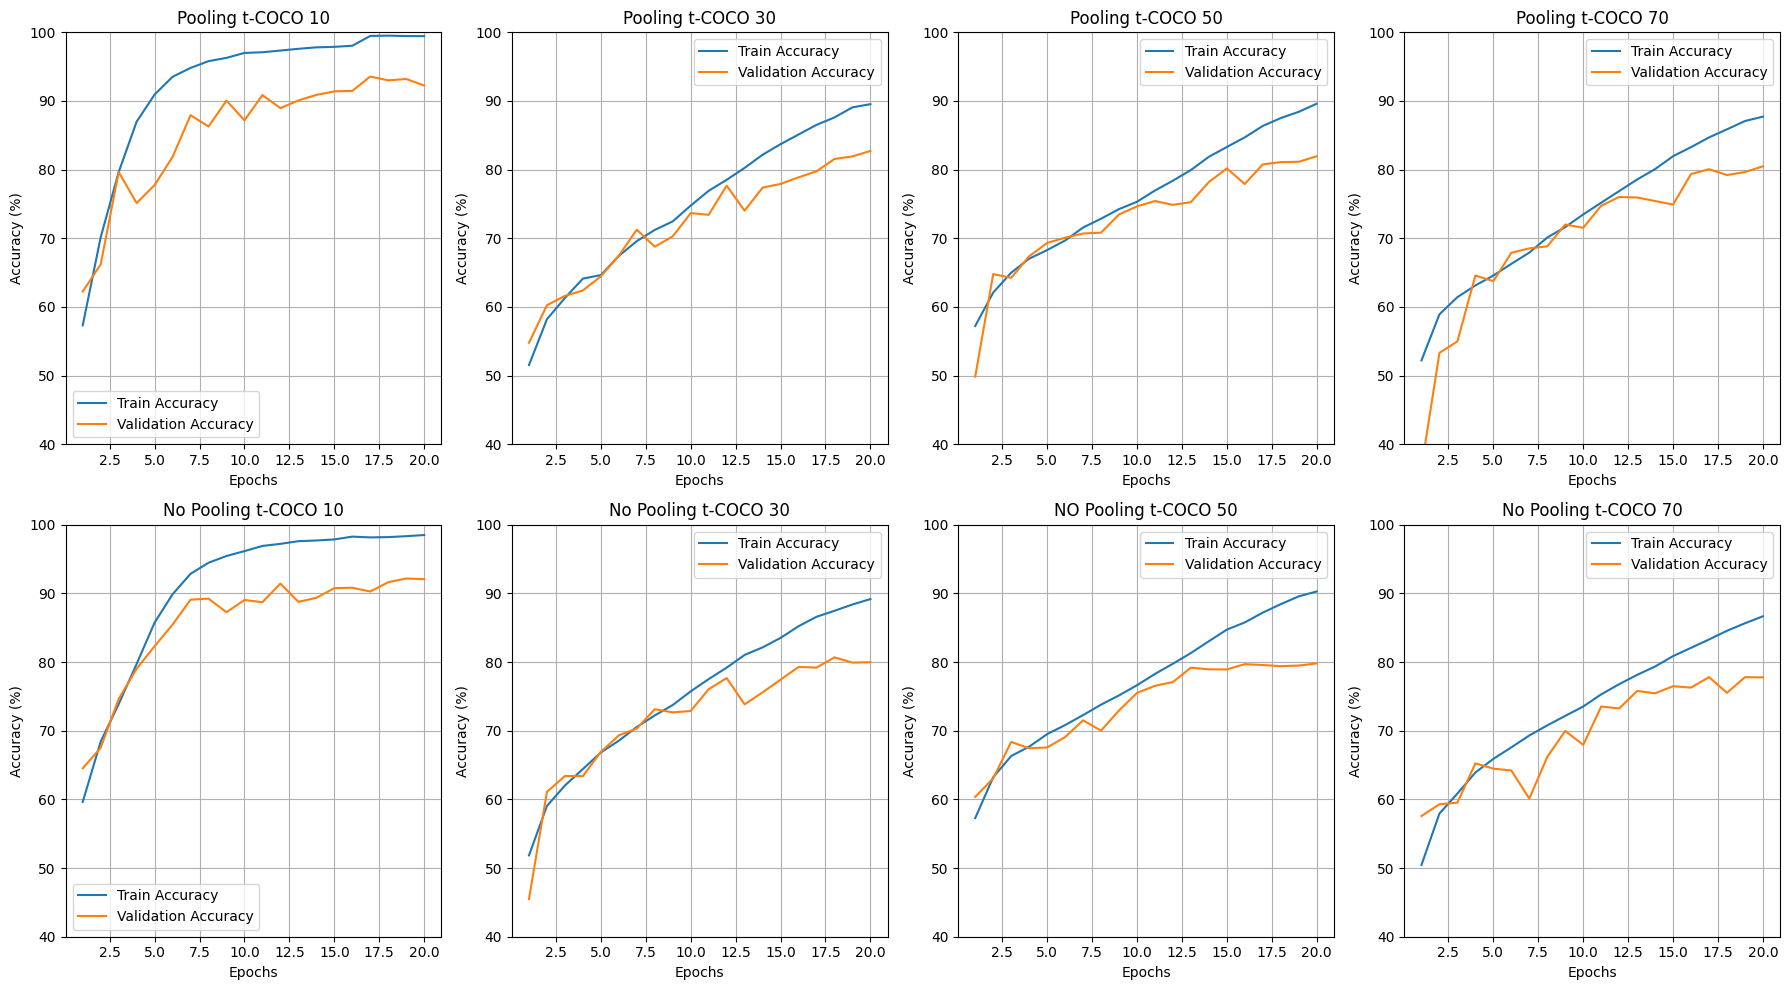

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting functions
def plot_accuracy(ax, data, title):
    epochs = np.arange(1, len(data['train_accuracy']) + 1)
    ax.plot(epochs, data['train_accuracy'], label='Train Accuracy')
    ax.plot(epochs, data['val_accuracy'], label='Validation Accuracy')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(40, 100)  # Set y-axis limits

# Plotting
fig, axs = plt.subplots(2, 4, figsize=(18, 10))

plot_accuracy(axs[0, 0], pooling_results_10, 'Pooling t-COCO 10')
plot_accuracy(axs[0, 1], pooling_results_30, 'Pooling t-COCO 30')
plot_accuracy(axs[0, 2], pooling_results_50, 'Pooling t-COCO 50')
plot_accuracy(axs[0, 3], pooling_results_70, 'Pooling t-COCO 70')
plot_accuracy(axs[1, 0], no_pooling_results_10, 'No Pooling t-COCO 10')
plot_accuracy(axs[1, 1], no_pooling_results_30, 'No Pooling t-COCO 30')
plot_accuracy(axs[1, 2], no_pooling_results_50, 'NO Pooling t-COCO 50')
plot_accuracy(axs[1, 3], no_pooling_results_70, 'No Pooling t-COCO 70')

plt.tight_layout()
plt.show()


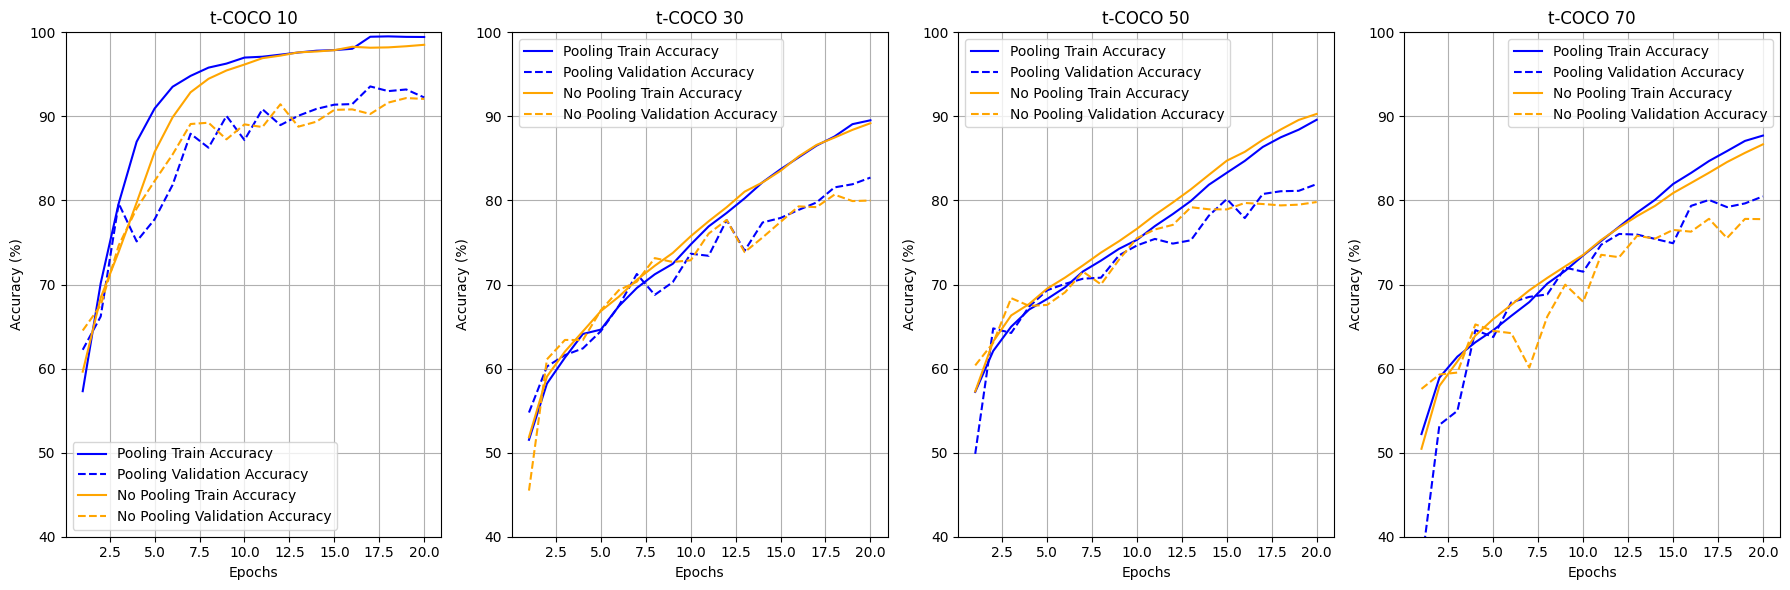

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting functions
def plot_accuracy(ax, data_pooling, data_no_pooling, title):
    epochs = np.arange(1, len(data_pooling['train_accuracy']) + 1)
    ax.plot(epochs, data_pooling['train_accuracy'], label='Pooling Train Accuracy', color='blue')
    ax.plot(epochs, data_pooling['val_accuracy'], label='Pooling Validation Accuracy', linestyle='--', color='blue')
    ax.plot(epochs, data_no_pooling['train_accuracy'], label='No Pooling Train Accuracy', color='orange')
    ax.plot(epochs, data_no_pooling['val_accuracy'], label='No Pooling Validation Accuracy', linestyle='--', color='orange')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(40, 100)  # Set y-axis limits

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(18, 6))

plot_accuracy(axs[0], pooling_results_10, no_pooling_results_10, 't-COCO 10')
plot_accuracy(axs[1], pooling_results_30, no_pooling_results_30, 't-COCO 30')
plot_accuracy(axs[2], pooling_results_50, no_pooling_results_50, 't-COCO 50')
plot_accuracy(axs[3], pooling_results_70, no_pooling_results_70, 't-COCO 70')

plt.tight_layout()
plt.show()
